# Build Sequence Model

In [1]:
import pandas as pd
from datasets import dataset_list
from sklearn.model_selection import StratifiedGroupKFold, RandomizedSearchCV
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.base import clone
import sglearn
from scipy import stats
import plotnine as gg
import numpy as np
from datetime import datetime
from joblib import Parallel, delayed

In [2]:
def get_predictive_performance(prediction_list):
    test_prediction_df = (pd.concat(prediction_list)
                          .rename({'dataset': 'testing_set'}, axis=1))
    predictive_performance = (test_prediction_df.groupby(['training_set', 'testing_set', 'fold'])
                              .apply(lambda df: stats.pearsonr(df['sgRNA Activity'], df['prediction'])[0])
                              .reset_index(name='pearson_r'))
    predictive_performance['relative_performance'] = (predictive_performance.groupby(['fold', 'testing_set'])
                                                      ['pearson_r']
                                                      .transform(lambda x: x/x.max()))
    median_relative_performance = (predictive_performance.groupby(['training_set'])
                                   .agg(median_performance = ('relative_performance', 'median'))
                                   .reset_index()
                                   .sort_values('median_performance'))
    predictive_performance['training_set'] = pd.Categorical(predictive_performance['training_set'],
                                                            categories=median_relative_performance['training_set'])
    if predictive_performance['testing_set'].isin(predictive_performance['training_set']).all():
        predictive_performance['testing_set'] = pd.Categorical(predictive_performance['testing_set'],
                                                               categories=median_relative_performance['training_set'])
    predictive_performance['fold'] = predictive_performance['fold'].astype('category')
    return predictive_performance


def plot_pearson_heatmap(predictive_performance):
    g = (gg.ggplot(predictive_performance) +
         gg.aes(x='testing_set', y='training_set', fill='pearson_r') +
         gg.geom_tile(color='black') +
         gg.scale_fill_cmap('RdBu_r', limits=(-1, 1)) +
         gg.theme_classic() +
         gg.theme(axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1)) +
         gg.facet_wrap('fold'))
    return g


def plot_relative_performance(predictive_performance):
    g = (gg.ggplot(predictive_performance) +
         gg.aes(x='training_set', y='relative_performance') +
         gg.geom_point(gg.aes(color='fold'), position=gg.position_dodge(width=0.5)) +
         gg.scale_color_brewer(type='qual', palette='Set2') +
         gg.geom_boxplot(fill=None, outlier_alpha=0) +
         gg.theme_classic() +
         gg.theme(axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1)))
    return g


def train_test_model(train_df, train_name, fold, model, test_df, X_test):
    X_train = sglearn.featurize_guides(train_df['sgRNA Context Sequence'])
    y_train = train_df['sgRNA Activity']
    model.fit(X_train,  y_train)
    dataset_test_predictions = test_df.copy()
    dataset_test_predictions['prediction'] = model.predict(X_test)
    dataset_test_predictions['training_set'] = train_name
    dataset_test_predictions['fold'] = fold
    return dataset_test_predictions


def get_fold_predictions(fold, fold_df,
                         base_model=LGBMRegressor(random_state=7),
                         top_training_set=None, top_datasets=None):
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    X_test = sglearn.featurize_guides(fold_test_data['sgRNA Context Sequence'])
    test_prediction_list = []
    if top_datasets is None:
        for dataset, dataset_df in fold_train_data.groupby('dataset'):
            dataset_df = dataset_df.reset_index(drop=True)
            if top_training_set is not None:
                if dataset != top_training_set:
                    top_dataset_df = fold_train_data[fold_train_data.dataset == top_training_set]
                    dataset_df = pd.concat([dataset_df, top_dataset_df]).reset_index(drop=True)
                    dataset_df['sgRNA Activity'] = (dataset_df.groupby('dataset')
                                                    ['sgRNA Activity']
                                                    .rank(pct=True))
                    dataset += ' + ' + top_training_set
            model = clone(base_model)
            dataset_test_predictions = train_test_model(dataset_df, dataset, fold, model, fold_test_data, X_test)
            test_prediction_list.append(dataset_test_predictions)
    else:
        train_df = fold_train_data[fold_train_data.dataset.isin(top_datasets)].reset_index(drop=True)
        train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                      ['sgRNA Activity']
                                      .rank(pct=True))
        model = clone(base_model)
        dataset_test_predictions = train_test_model(train_df, ' + '.join(top_datasets), fold,
                                                    model, fold_test_data, X_test)
        test_prediction_list.append(dataset_test_predictions)
    return test_prediction_list

In [3]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()

In [4]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

for ds in train_data_list:
    ds.load_data()
    ds.get_sgrnas()

## Cross-Validation Iterator

We'll use [StratifiedGroupKFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold)

>This cross-validation object is a variation of StratifiedKFold attempts to return stratified folds with
> non-overlapping groups. The folds are made by preserving the percentage of samples for each class.

>The same group will not appear in two different folds (the number of distinct groups has to be at least equal to
> the number of folds).

>The difference between GroupKFold and StratifiedGroupKFold is that the former attempts to create balanced folds such
> that the number of distinct groups is approximately the same in each fold, whereas StratifiedGroupKFold attempts to
> create folds which preserve the percentage of samples for each class as much as possible given the
> constraint of non-overlapping groups between splits.

In our case, we define each dataset as a "class", such that the datasets are approximately equally distributed across
folds, constrained by the notion that each "group" or gene cannot appear in both the train and test set in a given fold.

First, we assign sgRNAs to genes, capitalizing gene-names from the mouse libraries, so they overlap with the human annotations.
We can see that every context sequence uniquely targets a gene in this datset

In [5]:
sg_df_list = []
for ds in train_data_list:
    sg_df = ds.get_sg_df(include_group=True, include_activity=True)
    sg_df['dataset'] = ds.name
    sg_df_list.append(sg_df)
sg_df_groups = (pd.concat(sg_df_list)
                .groupby(['sgRNA Context Sequence'])
                .agg(n_conditions = ('sgRNA Context Sequence', 'count'),
                     target = ('sgRNA Target', lambda x: ', '.join(set([s.upper() for s in x if not pd.isna(s)]))))
                .reset_index())
sg_df_groups['target'].str.contains(',').sum()

0

We assign context sequences without a group to their own group. Every dataset appears as both a trainining and testing
dataset in every fold, except Doench2014_human Doench2014_mouse

In [6]:
# handle singleton case
sg_df_groups['target'] = sg_df_groups.apply(lambda row: row['target'] if (row['target'] != '') else row['sgRNA Context Sequence'], axis=1)
sg_df_class_groups = (pd.concat(sg_df_list)
                      .merge(sg_df_groups, how='inner', on='sgRNA Context Sequence')
                      .sort_values(['dataset', 'target'])                      
                      .reset_index(drop=True))
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
tidy_cv_list = []
for i, (train_index, test_index) in enumerate(sgkf.split(sg_df_class_groups, sg_df_class_groups.dataset, sg_df_class_groups.target)):
    train_df = sg_df_class_groups.iloc[train_index,:].copy()
    train_df['cv'] = i
    train_df['train'] = True
    tidy_cv_list.append(train_df)
    test_df = sg_df_class_groups.iloc[test_index,:].copy()
    test_df['cv'] = i
    test_df['train'] = False
    tidy_cv_list.append(test_df)

tidy_cv_df = pd.concat(tidy_cv_list)
cv_train_data_counts = (tidy_cv_df[['cv', 'train', 'dataset']].value_counts()
                        .reset_index(name='n'))
cv_train_data_counts

,cv,train,dataset,n
0,3,True,Kim2019_train,10604
1,1,True,Kim2019_train,10574
2,4,True,Kim2019_train,10354
3,0,True,Kim2019_train,10267
4,2,True,Kim2019_train,9529
5,2,False,Kim2019_train,3303
6,0,False,Kim2019_train,2565
7,4,False,Kim2019_train,2478
8,1,True,Doench2016,2319
9,1,False,Kim2019_train,2258


In [7]:
(cv_train_data_counts[['cv', 'dataset']]
 .value_counts()
 .reset_index(name='n'))

,cv,dataset,n
0,2,Doench2016,2
1,2,Doench2014_mouse,2
2,4,Kim2019_train,2
3,4,Doench2016,2
4,4,Doench2014_mouse,2
5,3,Wang2014,2
6,3,Kim2019_train,2
7,3,Doench2016,2
8,2,Wang2014,2
9,2,Kim2019_train,2


The size of the training and testing sets are approximately equal across folds,
with training sets varying between 20,431 - 24,919 sgRNas and testing sets varying between 3,932 - 8,420 sgRNAs


In [8]:
(tidy_cv_df[['cv','train']].value_counts()
 .reset_index(name='n')
 .sort_values(['cv', 'train']))

,cv,train,n
6,0,False,3843
3,0,True,14711
8,1,False,3033
1,1,True,15521
5,2,False,5447
4,2,True,13107
9,3,False,2707
0,3,True,15847
7,4,False,3524
2,4,True,15030


Indeed each gene target only appears in one fold

In [9]:
(tidy_cv_df[['cv','train', 'target']].value_counts()
 .reset_index(name='n')
 .query('n > 10')
 [['cv', 'target']].value_counts()
 .reset_index(name='train_test_sum')
 .groupby('cv')
 .agg({'train_test_sum': ['max']}))

,train_test_sum
,max
cv,
0,1
1,1
2,1
3,1
4,1


## Train each dataset separately

In [10]:
single_test_prediction_nested_list = Parallel(n_jobs=5)(delayed(get_fold_predictions)
                                                        (fold, df) for fold, df in tidy_cv_df.groupby('cv'))
single_test_prediction_list = [df for sublist in single_test_prediction_nested_list for df in sublist]
single_predictive_performance = get_predictive_performance(single_test_prediction_list)

LightGBMError: Do not support special JSON characters in feature name.

Importantly, all training datasets are successful at predicting held-out test data

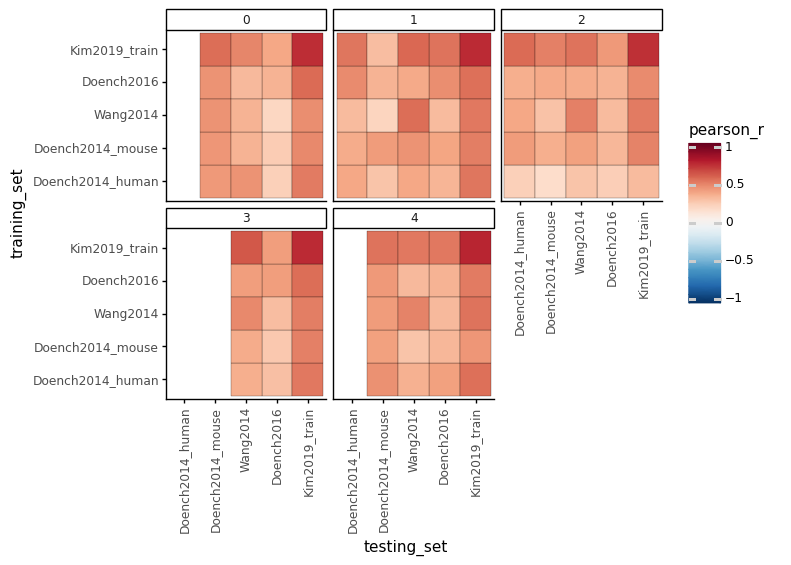

<ggplot: (8778980399312)>

In [24]:
plot_pearson_heatmap(single_predictive_performance)

We can see that the Kim training data outperforms all the rest, but it's also quite a bit bigger than the next biggest dataset

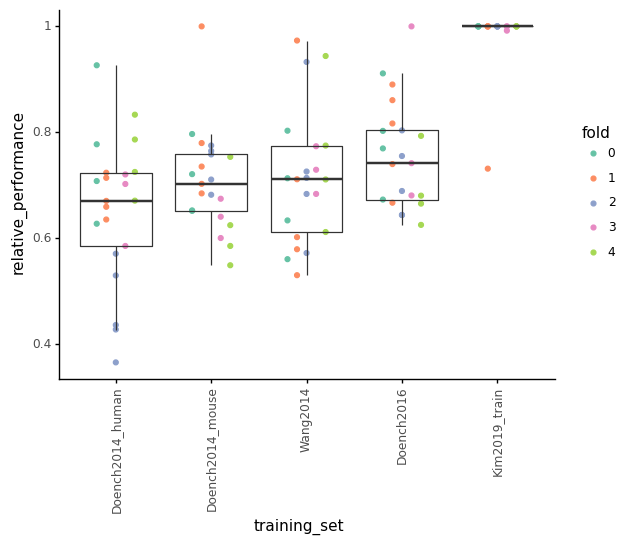

<ggplot: (8778980808982)>

In [25]:
plot_relative_performance(single_predictive_performance)


## Combining training datasets

If we merge the training datasets, can we improve our performance? We'll merge by normalizing activity to a percent rank.

In [27]:
top_training_set = 'Kim2019_train'

In [30]:
combined_test_prediction_nested_list = Parallel(n_jobs=5)(delayed(get_fold_predictions)
                                                          (fold, df, top_training_set=top_training_set)
                                                          for fold, df in tidy_cv_df.groupby('cv'))
combined_test_prediction_list = [df for sublist in combined_test_prediction_nested_list for df in sublist]
combined_predictive_performance = get_predictive_performance(combined_test_prediction_list)

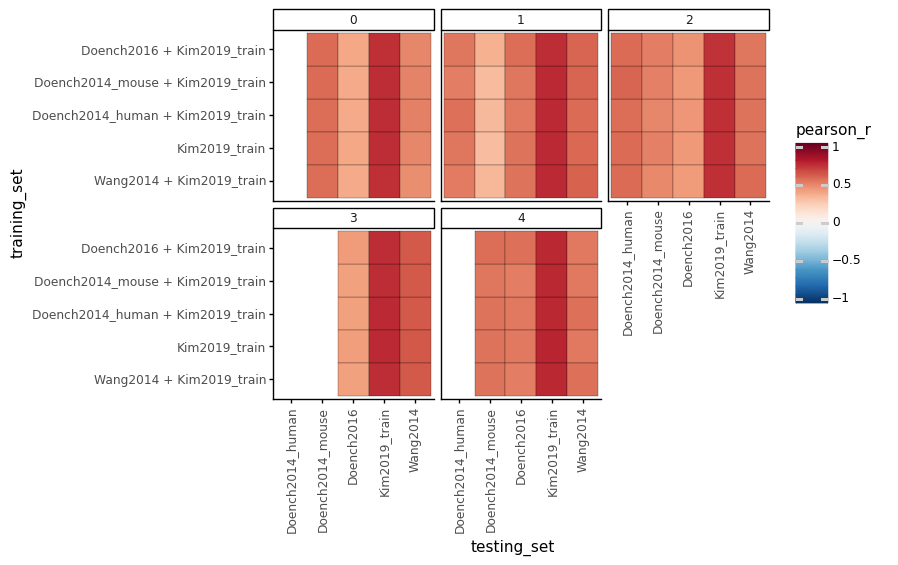

<ggplot: (8778975952996)>

In [31]:
plot_pearson_heatmap(combined_predictive_performance)

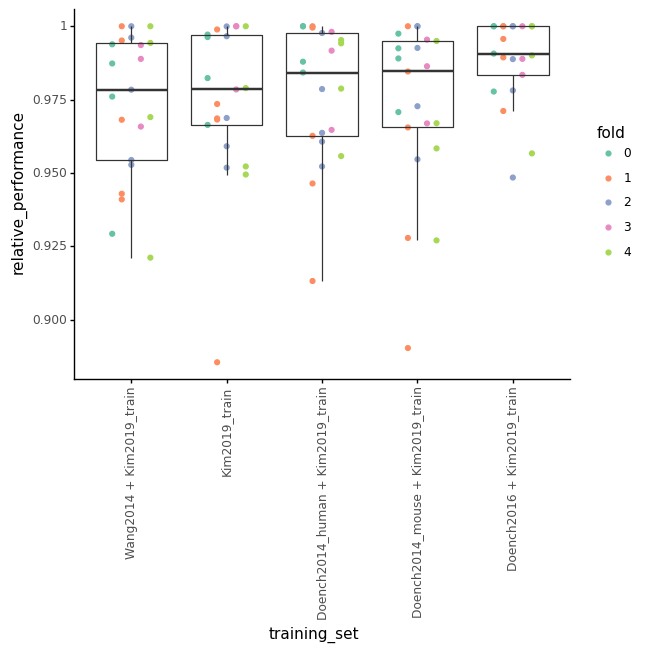

<ggplot: (8778986092279)>

In [32]:
plot_relative_performance(combined_predictive_performance)

In [33]:
ttest_list = []
reference_scores = (combined_predictive_performance
                    .loc[combined_predictive_performance['training_set'] == top_training_set, 'pearson_r'])
for training_set, training_set_df in combined_predictive_performance.groupby('training_set'):
    compare_scores = training_set_df['pearson_r']
    t, p = stats.ttest_rel(reference_scores, compare_scores)
    ttest_list.append({'training_set': training_set, 't': t, 'p': p})
ttest_df = pd.DataFrame(ttest_list)
ttest_df.sort_values('t')

,training_set,t,p
4,Doench2016 + Kim2019_train,-1.981595,0.061438
2,Doench2014_human + Kim2019_train,-0.492884,0.627462
0,Wang2014 + Kim2019_train,0.322286,0.750580
3,Doench2014_mouse + Kim2019_train,0.536218,0.597722
1,Kim2019_train,NaN,NaN


Given the increase in performance for at least some datasets, we'll try combining datasets

In [34]:
top_datasets = ['Kim2019_train', 'Doench2016', 'Doench2014_mouse', 'Wang2014', 'Doench2014_human'] # all

In [38]:
top_combined_test_prediction_nested_list = Parallel(n_jobs=5)(delayed(get_fold_predictions)
                                                              (fold, df, top_datasets=top_datasets)
                                                              for fold, df in tidy_cv_df.groupby('cv'))
top_combined_test_prediction_list = [df for sublist in top_combined_test_prediction_nested_list for df in sublist]
top_single_prediction_list = [df for df in single_test_prediction_list if (df.training_set == top_training_set).all()]
top_combined_predictive_performance = get_predictive_performance(top_combined_test_prediction_list +
                                                                 top_single_prediction_list)

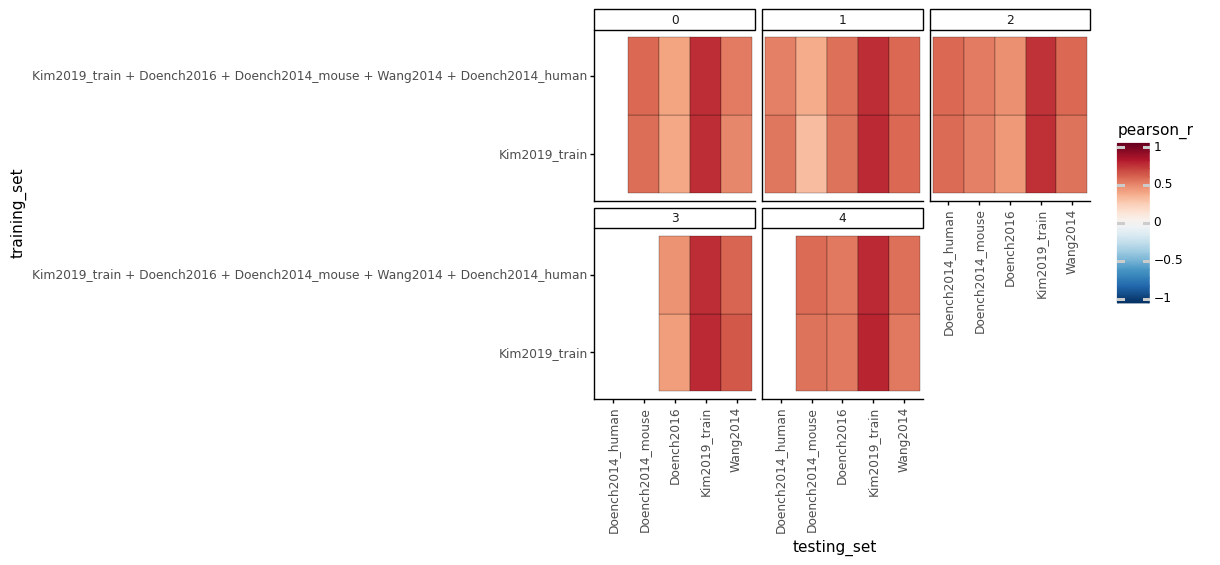

<ggplot: (8778974828740)>

In [39]:
plot_pearson_heatmap(top_combined_predictive_performance)

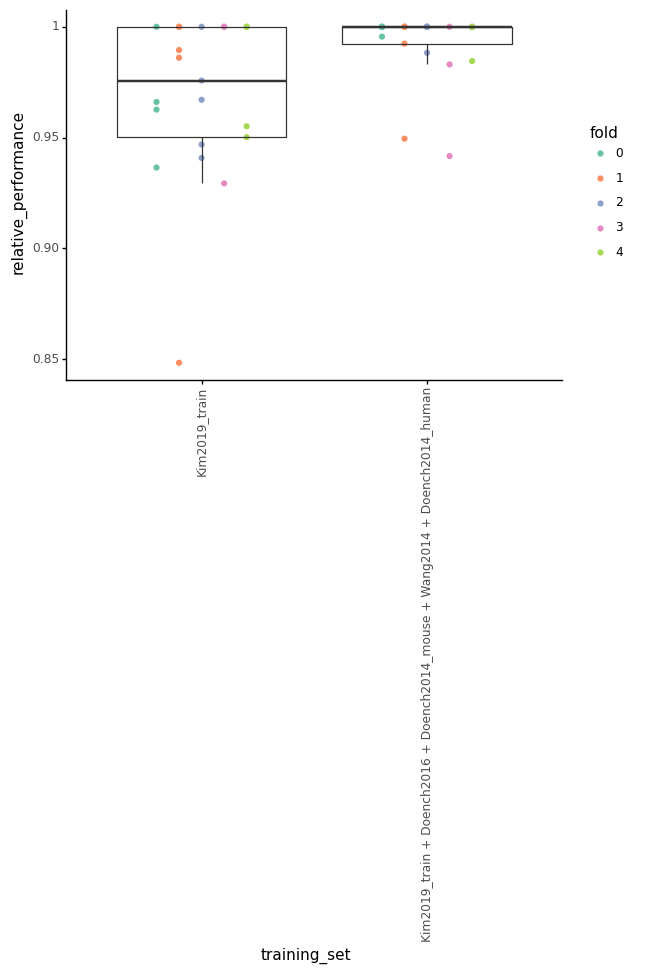

<ggplot: (8778978091087)>

In [40]:
plot_relative_performance(top_combined_predictive_performance)

In [41]:
t, p = stats.ttest_rel((top_combined_predictive_performance
                        .loc[top_combined_predictive_performance.training_set == top_training_set,
                             'pearson_r']),
                       top_combined_predictive_performance
                       .loc[top_combined_predictive_performance.training_set == ' + '.join(top_datasets),
                            'pearson_r'])
print('t: ' + str(round(t, 3)))
print('p: ' + str(round(p, 3)))

t: -2.016
p: 0.057


## Sequence Model Hyperparameter Tuning

Using the combined datasets, we'll try different model architectures and use hyperparameter tuning.

In [ ]:
param_iter = 10


In [ ]:
careful_gb = HistGradientBoostingRegressor(random_state=7, max_iter=1000, learning_rate=0.01, n_iter_no_change=20)
param_dist = {'max_depth': np.arange(2, 9),
              'subsample': stats.uniform(0, 1)}
get_fold_predictions(0, tidy_cv_df.query('cv == 0'), base_model=careful_gb,
                     top_datasets=top_datasets, param_dist=param_dist)

In [ ]:
gb_hyper_test_prediction_nested_list = Parallel(n_jobs=5)(delayed(get_fold_predictions)
                                                          (fold, df, base_model=careful_gb,
                                                           top_datasets=top_datasets,
                                                           param_dist=param_dist)
                                                          for fold, df in tidy_cv_df.groupby('cv'))
gb_hyper_test_prediction_list = [df for sublist in gb_hyper_test_prediction_nested_list for df in sublist]
gb_hyper_predictive_performance = get_predictive_performance(gb_hyper_test_prediction_list +
                                                             top_combined_test_prediction_list)

In [45]:
gb_hyperparameter_model_dict = {}
gb_hyperparameter_test_prediction_list = []

for fold, fold_df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    X_test = sglearn.featurize_guides(fold_test_data['sgRNA Context Sequence'])
    dataset_df = fold_train_data[fold_train_data.dataset.isin(top_datasets)].reset_index(drop=True)
    dataset_df['sgRNA Activity'] = (dataset_df.groupby('dataset')
                                    ['sgRNA Activity']
                                    .rank(pct=True))
    X_train = sglearn.featurize_guides(dataset_df['sgRNA Context Sequence'])
    y_train = dataset_df['sgRNA Activity']
    model = GradientBoostingRegressor(random_state=7, n_estimators=1000, learning_rate=0.01,
                                      n_iter_no_change=20, max_depth=6)
    model.fit(X_train, y_train)
    gb_hyperparameter_model_dict['GB'] = model
    dataset_test_predictions = fold_test_data.copy()
    dataset_test_predictions['prediction'] = model.predict(X_test)
    dataset_test_predictions['training_set'] = 'GB'
    dataset_test_predictions['fold'] = fold
    gb_hyperparameter_test_prediction_list.append(dataset_test_predictions)
    print('\n')

Fold: 0


Fold: 1


Fold: 2


Fold: 3


Fold: 4




In [46]:
gb_hyper_predictive_performance = get_predictive_performance(gb_hyperparameter_test_prediction_list +
                                                             top_combined_test_prediction_list)

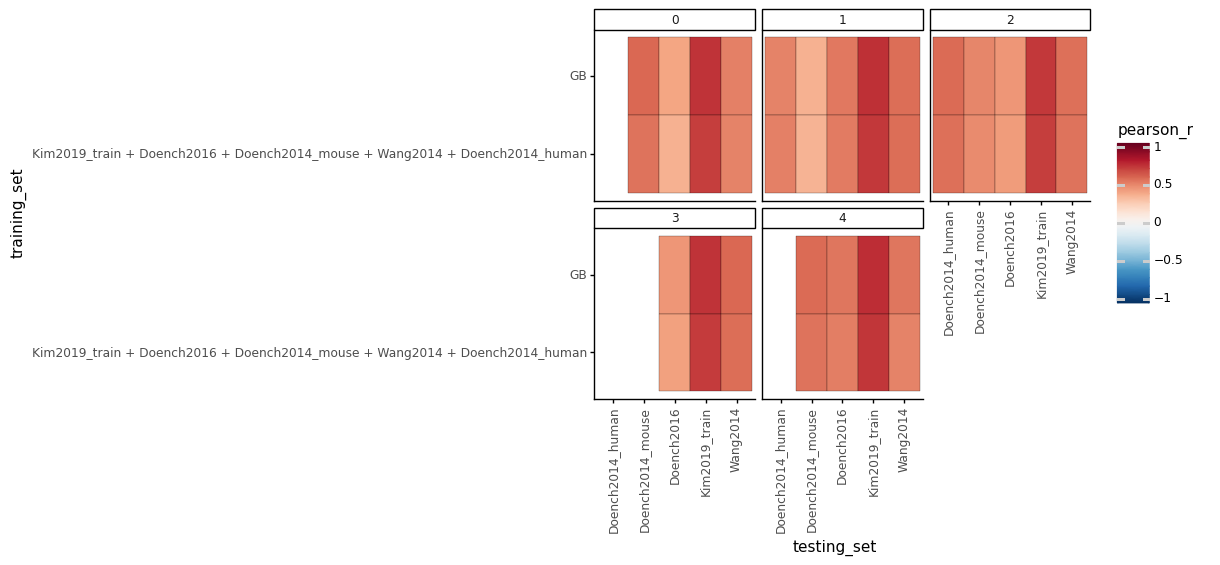

<ggplot: (8785907993552)>

In [47]:
plot_pearson_heatmap(gb_hyper_predictive_performance)

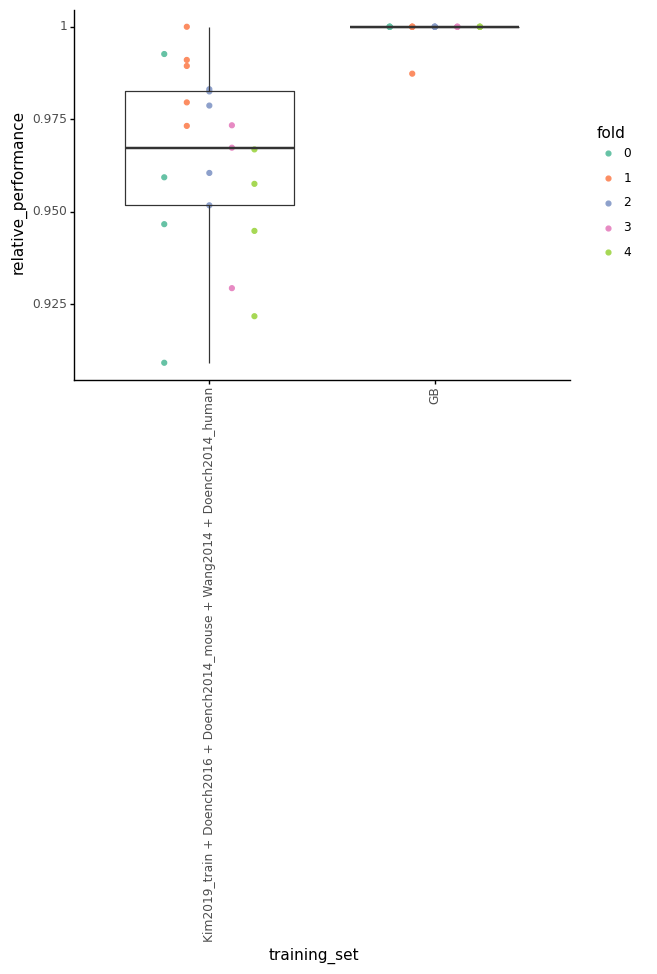

<ggplot: (8785906364549)>

In [48]:
plot_relative_performance(gb_hyper_predictive_performance)

In [57]:
hist_model_dict = {}
hist_test_prediction_list = []

for fold, fold_df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    start = datetime.now()
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    X_test = sglearn.featurize_guides(fold_test_data['sgRNA Context Sequence'])
    dataset_df = fold_train_data[fold_train_data.dataset.isin(top_datasets)].reset_index(drop=True)
    dataset_df['sgRNA Activity'] = (dataset_df.groupby('dataset')
                                    ['sgRNA Activity']
                                    .rank(pct=True))
    X_train = sglearn.featurize_guides(dataset_df['sgRNA Context Sequence'])
    y_train = dataset_df['sgRNA Activity']
    model = HistGradientBoostingRegressor(random_state=7, max_iter=1000, learning_rate=0.01,
                                          n_iter_no_change=20, max_depth=6)
    model.fit(X_train, y_train)
    hist_model_dict['Hist'] = model
    dataset_test_predictions = fold_test_data.copy()
    dataset_test_predictions['prediction'] = model.predict(X_test)
    dataset_test_predictions['training_set'] = 'Hist'
    dataset_test_predictions['fold'] = fold
    hist_test_prediction_list.append(dataset_test_predictions)
    end = datetime.now()
    print(end - start)
    print('\n')

Fold: 0
0:00:46.610600


Fold: 1
0:00:50.592597


Fold: 2
0:00:45.134297


Fold: 3
0:00:45.830103


Fold: 4
0:00:45.569582




In [58]:
hist_predictive_performance = get_predictive_performance(hist_test_prediction_list +
                                                         gb_hyperparameter_test_prediction_list +
                                                         top_combined_test_prediction_list)

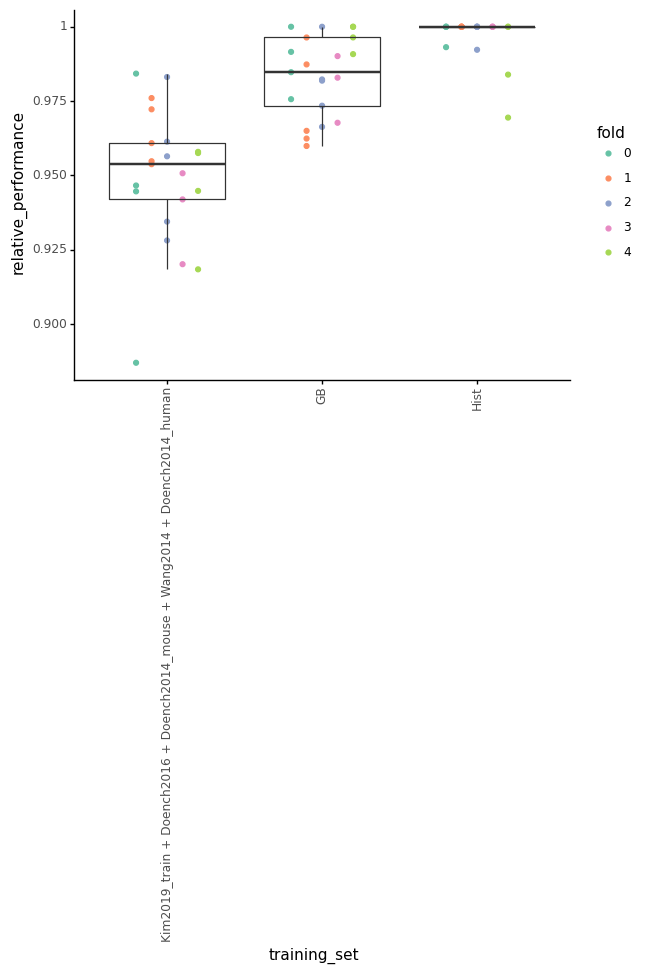

<ggplot: (8785877913992)>

In [59]:
plot_relative_performance(hist_predictive_performance)